In [1]:
# Input info
indir = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_30/"
outdir = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/dendro_bc/knn_kparam_30/"
condition = "inputOnly"
donor = 0

# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_prefilterMerge_impute/dendro_bc/results/inputOnly/knn/kparam_30"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_prefilterMerge_impute/donors/donor1/dendro_bc/knn_kparam_30"
# condition = "inputOnly"
# donor = 1

# params
p_thresh = 0.1 

atac_col = "cluster_labels"
clone_col = "den_clust" #den_clust, "Variants", "den_clust"


In [2]:
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
don_indir =  join(indir,"sepDonors", f"donor{donor}")
df = pd.read_csv(join(don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)
hyper = pd.read_csv(join(don_indir, "hypergeo_padjusted.csv"),  index_col=0)
df

,index,variable,value,method
0,1_C1,0,0.0,global_all
1,1_C1,1,0.0,global_all
2,1_C1,2,0.0,global_all
3,1_C1,3,0.0,global_all
4,1_C1,4,0.0,global_all
5,1_C1,5,0.0,global_all
6,1_C1,6,0.0,global_all
7,1_C1,7,0.0,global_all
8,1_C1,8,0.0,global_all
9,1_C1,9,0.0,global_all


In [4]:
ncells_f = join(don_indir, 'ncells.csv')
out_ncells_f = join(outdir, f'{condition}_ncells.csv')

adjHyper_f = join(don_indir, "hypergeo_padjusted.csv")
out_adjHyper_f = join(outdir, "hypergeo_padjusted.csv")
cmd = f"cp {adjHyper_f} {out_adjHyper_f}"
!{cmd}

ncells = pd.read_csv(ncells_f)

# if clone_col not in ncells.columns:
#     raise ValueError(f"{clone_col} not in columns {ncells.columns}")
ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_ncells_f)

In [5]:
hyper

,0,1,2,3,4,5,6,7,8,9
1_C1,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999,0.09999


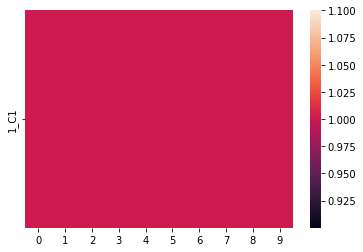

In [6]:
hyper = pd.read_csv(adjHyper_f, index_col=0)
if (hyper.shape[0]==1) or (hyper.shape[1]==1) :
    f = plt.figure()
    sns.heatmap(-np.log10(hyper))
    plt.savefig(join(outdir, f"hyper_padj.pdf"),dpi=300, bbox_inches = "tight")
elif len(hyper) > 1:
    g=sns.clustermap(-np.log10(hyper))
    g.fig.suptitle(f"{condition} (-log 10 pvalue, 1 is p=0.1)")
    #inds = g.dendrogram_row.dendrogram["leaves"]
    #cols = g.dendrogram_col.dendrogram["leaves"]
    g.fig.savefig(join(outdir, f"hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

    


In [7]:
# save to combined directory
df.to_csv(join(outdir, "shuffle_results_pvals.csv"))
hyper.to_csv(join(outdir, "hypergeo_pvals.csv"))


## Get overlapping clones and clusters and use same clone indices from input to noInput

clone_all
clone_min
global_all
global_min


<Figure size 432x288 with 0 Axes>

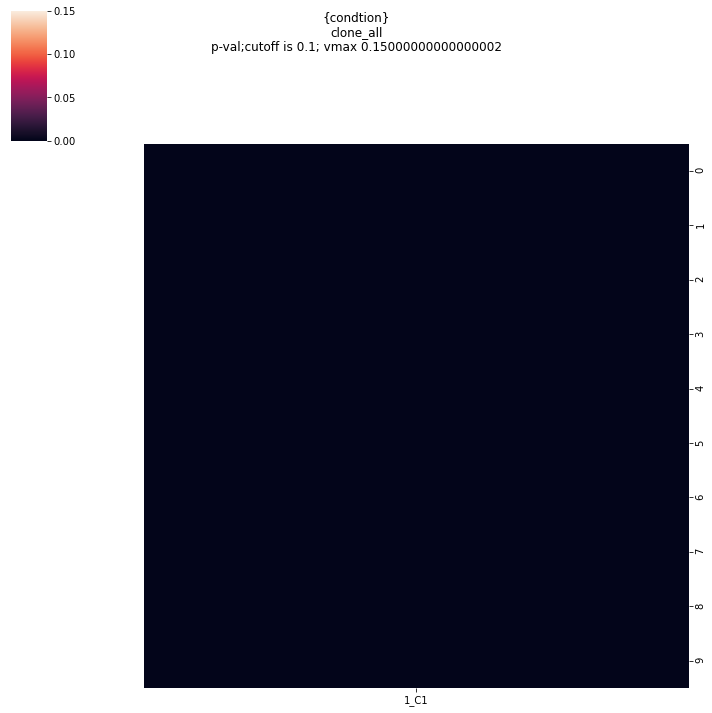

<Figure size 432x288 with 0 Axes>

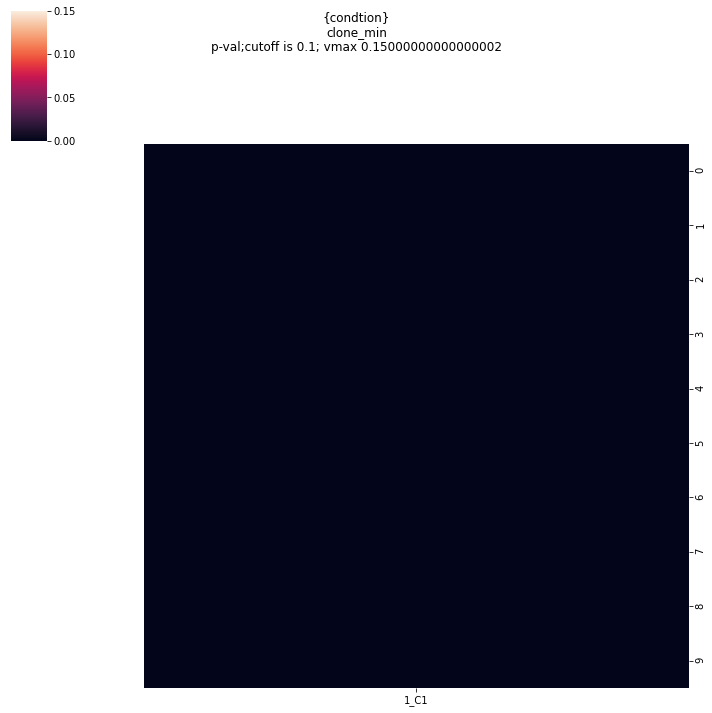

<Figure size 432x288 with 0 Axes>

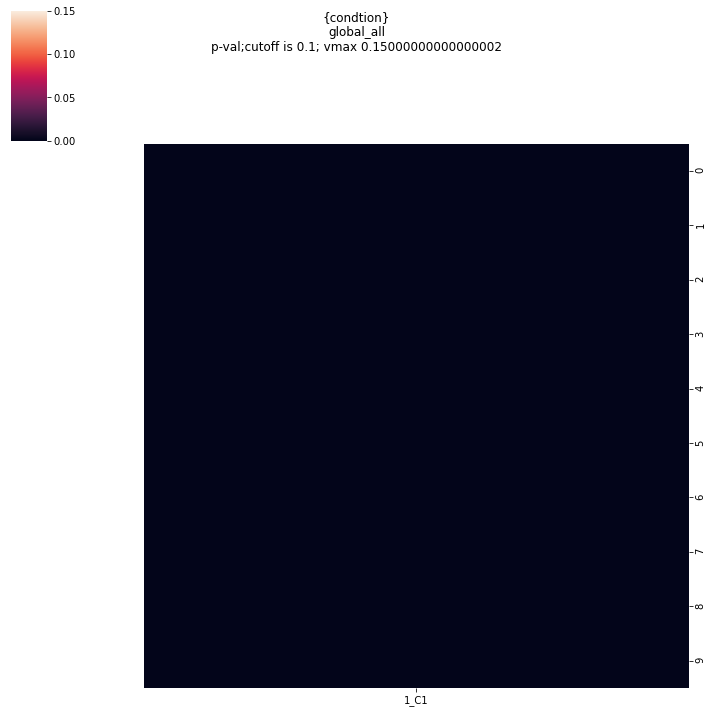

<Figure size 432x288 with 0 Axes>

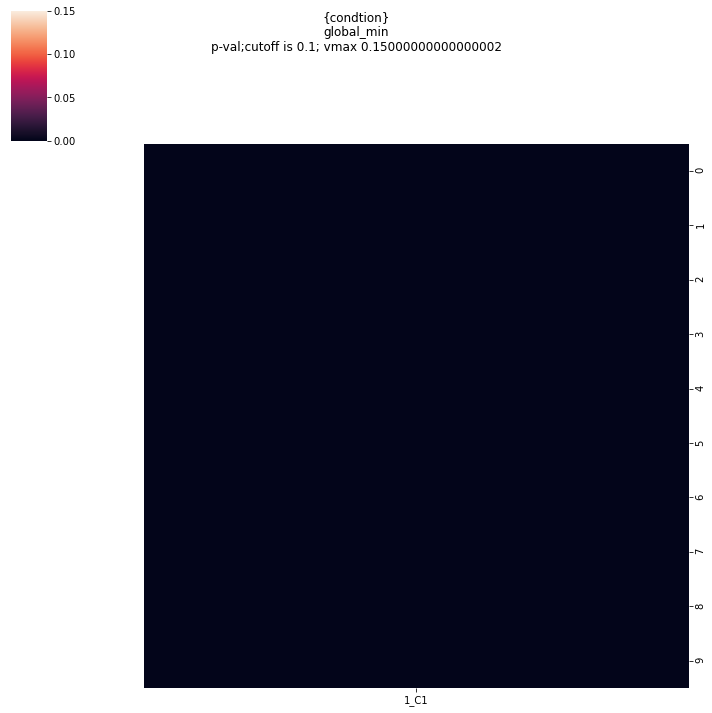

In [8]:
for ind, val in df[df["value"] < p_thresh].groupby("method"):
    print(ind)
    
    clones = set(val["index"].values)
    curr_clones = list(clones)
    #curr_clones = list(noclones.union(clones))
    
    clust = set(val["variable"].values)
    curr_clust = list(clust) # list(noclust.union(clust))
    
    if (len(curr_clust)==0 or len(curr_clones)==0):
        print('no significant results')
        print(ind)
        continue
       
    curr_df = pd.DataFrame(index=curr_clones, columns=curr_clust)    
    val = val.set_index(["index", "variable"]) 
 
    def get_element_pval(x,y, val):
        if (y.name, x.name) in val.index:
            return val.loc[(y.name, x.name), "value"]
        else: 
            return 1
    curr_df = curr_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=val), axis=1))
    
  
    # Transpose both matrices
    curr_df = curr_df.transpose()
    
    # Plot the input first and then noInput with same clone indices
    if (curr_df.shape[0] > 1) and (curr_df.shape[1] > 1):
        g = sns.clustermap(curr_df, vmax=float(p_thresh)+0.05, figsize=(12,12))
        cols = g.dendrogram_col.dendrogram["leaves"]
    else:
        f = plt.figure()
        g = sns.clustermap(curr_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)

    title = f"{ind}\np-val;cutoff is {p_thresh}; vmax {float(p_thresh)+0.05}"
    g.fig.suptitle("{condtion}\n" + title)
    g.fig.savefig(join(outdir, f"{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    